# DNN 성능 향상시키기
- 앞에서 추가한 LAG와 휴일포함 데이터를 기존의 DNN에 훈련하여 차이를 확인

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import os
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## LAG 데이터만 포함

In [59]:
df = pd.read_csv('data/훈련데이터셋/2_훈련데이터셋_LAG포함.csv')
df = df.drop(columns='날짜')

# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,지역코드,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워,lag_1d,lag_7d
0,1111010100,-1.5,6.5,3.5,9.6,52.5,147993.0770,141284.2660,146294.6135
1,1111010100,-2.0,6.2,5.3,9.6,73.4,161767.3595,147993.0770,175633.8270
2,1111010100,-6.4,6.1,4.5,9.6,70.8,170183.9965,161767.3595,156084.1910
3,1111010100,-8.5,5.4,3.6,9.6,79.1,184245.9485,184582.8110,177018.8420
4,1111010100,-9.6,5.0,2.1,9.6,56.9,176717.5230,184245.9485,158467.1690


### 데이터셋 나누기

In [60]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((152212, 8), (152212,))

In [61]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 8), (30443, 8), (121769,), (30443,))

### 훈련데이터 전처리
- 지역코드는 원핫인코딩 처리
- 나머지는 정규화 처리

In [62]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if col!='지역코드'])]
    )

In [63]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed.shape

(121769, 473)

In [ ]:
# 전처리 모델 저장하기
import joblib
joblib.dump(preprocessor, 'model/SimpleDNNwithLAG/preprocessor_LAG.joblib')

['model/preprocessor_LAG.joblib']

### 모델생성

In [42]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               242688    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)               

In [43]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/SimpleDNNwithLAG/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 14s 5ms/step - loss: 23519744000.0000 - mae: 32488.3906 - mse: 23519744000.0000 - val_loss: 7788783104.0000 - val_mae: 24162.2520 - val_mse: 7788783104.0000
Epoch 2/100
3045/3045 [==============================] - 13s 4ms/step - loss: 15186055168.0000 - mae: 23537.8906 - mse: 15186055168.0000 - val_loss: 6446730240.0000 - val_mae: 15402.3486 - val_mse: 6446730240.0000
Epoch 3/100
3045/3045 [==============================] - 13s 4ms/step - loss: 14770765824.0000 - mae: 22921.5938 - mse: 14770765824.0000 - val_loss: 8391885824.0000 - val_mae: 20921.2715 - val_mse: 8391885824.0000
Epoch 4/100
3045/3045 [==============================] - 14s 4ms/step - loss: 14780815360.0000 - mae: 23142.4258 - mse: 14780815360.0000 - val_loss: 8997999616.0000 - val_mae: 20356.6152 - val_mse: 8997999616.0000
Epoch 5/100
3045/3045 [==============================] - 13s 4ms/step - loss: 15016916992.0000 - mae: 23320.6641 - mse: 15016916992.0000 - val_l

In [44]:
# 테스트 해보기
X_test_preprocessor = preprocessor.transform(X_test)
test_loss, test_mae, test_mse = model.evaluate(X_test_preprocessor.toarray(), y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 8611793920.00
  MAE: 15485.98
  RMSE: 92799.75


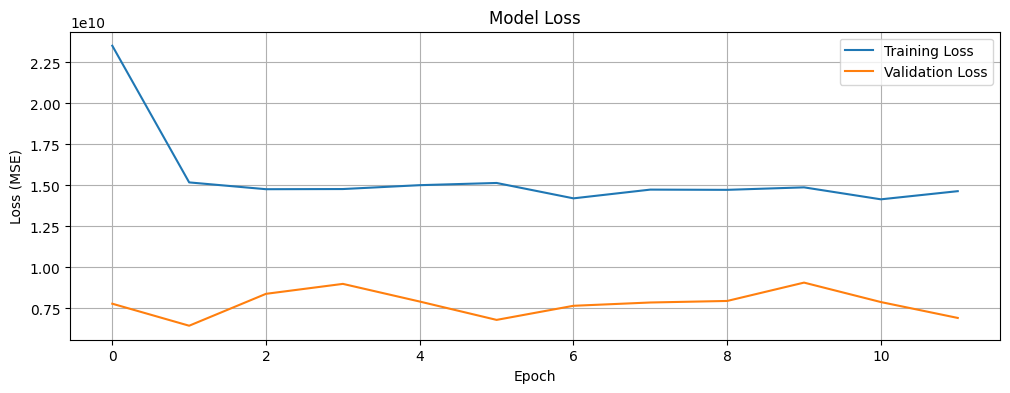

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [48]:
#모델 저장
model.save('model/SimpleDNNwithLAG/final_model.h5')

## LAG+휴일여부

In [69]:
df = pd.read_csv('data/훈련데이터셋/3_훈련데이터셋_LAG_휴일포함.csv')
df = df.drop(columns='날짜')
df['휴일여부'] = df['휴일여부'].astype(int)
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,지역코드,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워,lag_1d,lag_7d,휴일여부
0,1111010100,-1.5,6.5,3.5,9.6,52.5,147993.0770,141284.2660,146294.6135,1
1,1111010100,-2.0,6.2,5.3,9.6,73.4,161767.3595,147993.0770,175633.8270,0
2,1111010100,-6.4,6.1,4.5,9.6,70.8,170183.9965,161767.3595,156084.1910,0
3,1111010100,-8.5,5.4,3.6,9.6,79.1,184245.9485,184582.8110,177018.8420,0
4,1111010100,-9.6,5.0,2.1,9.6,56.9,176717.5230,184245.9485,158467.1690,0


### 데이터셋 나누기

In [70]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((152212, 9), (152212,))

In [71]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 9), (30443, 9), (121769,), (30443,))

### 훈련데이터 전처리

In [72]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if (col!='지역코드') & (col!='휴일여부')])],
    remainder='passthrough'
    )

In [73]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1010283 stored elements and shape (121769, 474)>

In [ ]:
# 전처리 모델 저장하기
import joblib
joblib.dump(preprocessor, 'model/SimpleDNNwithLAG_Holiday/preprocessor_LAG_holiday.joblib')

['model/preprocessor_LAG_holiday.joblib']

### 모델생성

In [75]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               243200    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)               

In [76]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/SimpleDNNwithLAG_Holiday/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 15s 5ms/step - loss: 17931771904.0000 - mae: 28676.4180 - mse: 17931771904.0000 - val_loss: 18190381056.0000 - val_mae: 29699.0605 - val_mse: 18190381056.0000
Epoch 2/100
3045/3045 [==============================] - 14s 4ms/step - loss: 13271878656.0000 - mae: 21130.3281 - mse: 13271878656.0000 - val_loss: 13689044992.0000 - val_mae: 25732.0137 - val_mse: 13689044992.0000
Epoch 3/100
3045/3045 [==============================] - 14s 4ms/step - loss: 12822465536.0000 - mae: 21668.7656 - mse: 12822465536.0000 - val_loss: 10754695168.0000 - val_mae: 15396.8975 - val_mse: 10754695168.0000
Epoch 4/100
3045/3045 [==============================] - 14s 4ms/step - loss: 12803878912.0000 - mae: 20857.4297 - mse: 12803878912.0000 - val_loss: 10787485696.0000 - val_mae: 15053.1299 - val_mse: 10787485696.0000
Epoch 5/100
3045/3045 [==============================] - 14s 4ms/step - loss: 12892829696.0000 - mae: 19735.1113 - mse: 12892829696.0000

In [77]:
# 테스트 해보기
X_test_preprocessor = preprocessor.transform(X_test)
test_loss, test_mae, test_mse = model.evaluate(X_test_preprocessor.toarray(), y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 9555895296.00
  MAE: 14299.25
  RMSE: 97754.26


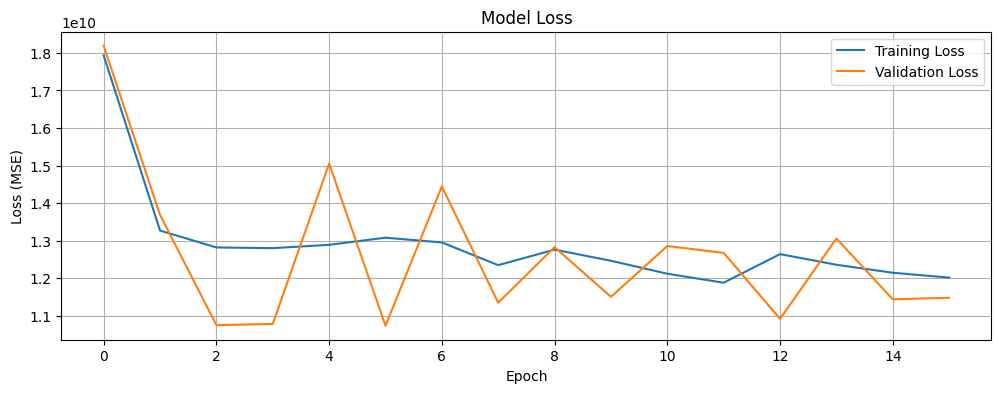

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [79]:
#모델 저장
model.save('model/SimpleDNNwithLAG_Holiday/final_model.h5')

## Embedding Layer 사용하기

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Embedding, Flatten
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### LAG/휴일유무 없이

In [9]:
# 데이터 가져오기
df = pd.read_csv('data/훈련데이터셋/1_훈련데이터셋_날짜미포함.csv')

X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((145126, 6), (36282, 6), (145126,), (36282,))

In [10]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])

X_test_region = label_encoder.transform(X_test['지역코드'])

num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if col != '지역코드']
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
joblib.dump(label_encoder, 'model/EmbeddingDNN/labelEncoder.joblib')
joblib.dump(scaler, 'model/EmbeddingDNN/standardScaler.joblib')


법정동 수: 466
나머지 데이터 수: (145126, 5)


['model/EmbeddingDNN/standardScaler.joblib']

In [11]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten_1 (Flatten)            (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 5)]          0           []                               
                                                                                            

In [12]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/EmbeddingDNN/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3629/3629 [==============================] - 17s 4ms/step - loss: 51053395968.0000 - mae: 49776.3281 - mse: 51053395968.0000 - val_loss: 30627362816.0000 - val_mae: 33740.2422 - val_mse: 30627362816.0000
Epoch 2/100
3629/3629 [==============================] - 23s 6ms/step - loss: 42351329280.0000 - mae: 37504.5469 - mse: 42351329280.0000 - val_loss: 30413539328.0000 - val_mae: 30828.8984 - val_mse: 30413539328.0000
Epoch 3/100
3629/3629 [==============================] - 24s 6ms/step - loss: 40986296320.0000 - mae: 35378.1797 - mse: 40986296320.0000 - val_loss: 31603439616.0000 - val_mae: 31170.6094 - val_mse: 31603439616.0000
Epoch 4/100
3629/3629 [==============================] - 26s 7ms/step - loss: 40373293056.0000 - mae: 33881.6875 - mse: 40373293056.0000 - val_loss: 36147728384.0000 - val_mae: 30891.9355 - val_mse: 36147728384.0000
Epoch 5/100
3629/3629 [==============================] - 24s 7ms/step - loss: 39623086080.0000 - mae: 33422.0117 - mse: 39623086080.0000

In [13]:
test_loss, test_mae, test_mse = model.evaluate([X_test_region, X_test_numeric], y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 26826100736.00
  MAE: 25335.65
  RMSE: 163786.75


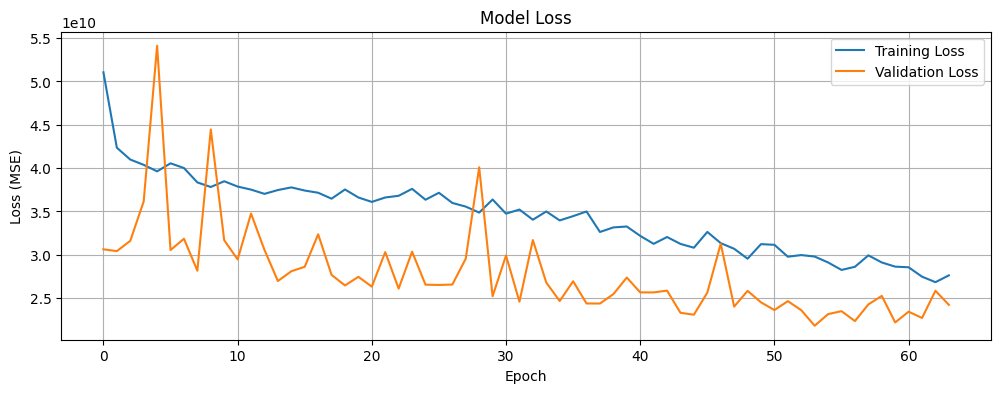

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [15]:
model.save('model/EmbeddingDNN/final_model.h5')

### LAG 포함

In [30]:
# 데이터 가져오기
df = pd.read_csv('data/훈련데이터셋/2_훈련데이터셋_LAG포함.csv')
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)

X = df.drop(columns=['파워','날짜'])
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 8), (30443, 8), (121769,), (30443,))

In [31]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])

X_test_region = label_encoder.transform(X_test['지역코드'])

num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if col != '지역코드']
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
joblib.dump(label_encoder, 'model/EmbeddingDNNwithLAG/labelEncoder.joblib')
joblib.dump(scaler, 'model/EmbeddingDNNwithLAG/standardScaler.joblib')


법정동 수: 466
나머지 데이터 수: (121769, 7)


['model/EmbeddingDNNwithLAG/standardScaler.joblib']

In [32]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten_4 (Flatten)            (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 7)]          0           []                               
                                                                                            

In [33]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/EmbeddingDNNwithLAG/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 12s 4ms/step - loss: 18528413696.0000 - mae: 31212.4473 - mse: 18528413696.0000 - val_loss: 14880436224.0000 - val_mae: 18395.5332 - val_mse: 14880436224.0000
Epoch 2/100
3045/3045 [==============================] - 11s 4ms/step - loss: 12268414976.0000 - mae: 23214.5449 - mse: 12268414976.0000 - val_loss: 14637991936.0000 - val_mae: 18794.7500 - val_mse: 14637991936.0000
Epoch 3/100
3045/3045 [==============================] - 12s 4ms/step - loss: 12674151424.0000 - mae: 22006.9629 - mse: 12674151424.0000 - val_loss: 14163519488.0000 - val_mae: 17524.1777 - val_mse: 14163519488.0000
Epoch 4/100
3045/3045 [==============================] - 12s 4ms/step - loss: 11747168256.0000 - mae: 20935.8320 - mse: 11747168256.0000 - val_loss: 14176168960.0000 - val_mae: 17084.2598 - val_mse: 14176168960.0000
Epoch 5/100
3045/3045 [==============================] - 12s 4ms/step - loss: 12153318400.0000 - mae: 21143.9961 - mse: 12153318400.0000

In [34]:
test_loss, test_mae, test_mse = model.evaluate([X_test_region, X_test_numeric], y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 11641968640.00
  MAE: 15343.60
  RMSE: 107897.95


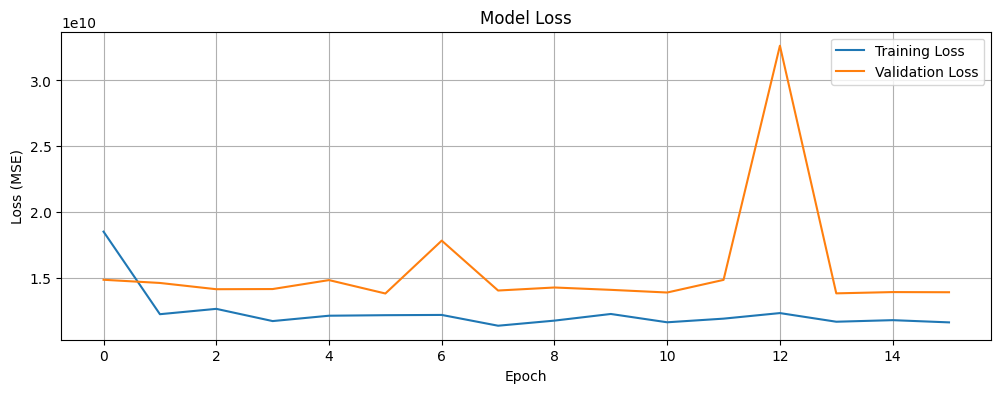

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [36]:
model.save('model/EmbeddingDNNwithLAG/final_model.h5')

### LAG+휴일 포함

In [10]:
df = pd.read_csv('data/훈련데이터셋/3_훈련데이터셋_LAG_휴일포함.csv')
df['휴일여부'] = df['휴일여부'].astype(int)
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)

X = df.drop(columns=['파워','날짜'])
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 9), (30443, 9), (121769,), (30443,))

In [11]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])

X_test_region = label_encoder.transform(X_test['지역코드'])

num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# binary 데이터
binary_cols = ['휴일여부']
X_train_binary = X_train[binary_cols].values
X_test_binary = X_test[binary_cols].values

# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if (col != '지역코드') & (col not in binary_cols)]
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric_scaled = scaler.transform(X_test[numeric_cols])

# 숫자 데이터 합치기
X_train_numeric = np.concatenate([X_train_numeric_scaled, X_train_binary], axis=1)
X_test_numeric = np.concatenate([X_test_numeric_scaled, X_test_binary], axis=1)

print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
joblib.dump(label_encoder, 'model/EmbeddingDNNwithLAG_Holiday/labelEncoder.joblib')
joblib.dump(scaler, 'model/EmbeddingDNNwithLAG_Holiday/standardScaler.joblib')


법정동 수: 466
나머지 데이터 수: (121769, 8)


['model/EmbeddingDNNwithLAG_Holiday/standardScaler.joblib']

In [12]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten_1 (Flatten)            (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 8)]          0           []                               
                                                                                            

In [13]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

path = './model/EmbeddingDNNwithLAG_Holiday/'
if not os.path.exists(path):
    os.mkdir(path)
filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 9s 3ms/step - loss: 19709990912.0000 - mae: 31401.9902 - mse: 19709990912.0000 - val_loss: 15102926848.0000 - val_mae: 24445.5000 - val_mse: 15102926848.0000
Epoch 2/100
3045/3045 [==============================] - 8s 3ms/step - loss: 12386648064.0000 - mae: 22726.3516 - mse: 12386648064.0000 - val_loss: 16665678848.0000 - val_mae: 25406.2129 - val_mse: 16665678848.0000
Epoch 3/100
3045/3045 [==============================] - 8s 3ms/step - loss: 12526903296.0000 - mae: 21617.6074 - mse: 12526903296.0000 - val_loss: 13094548480.0000 - val_mae: 17527.8965 - val_mse: 13094548480.0000
Epoch 4/100
3045/3045 [==============================] - 8s 3ms/step - loss: 13355686912.0000 - mae: 21360.8535 - mse: 13355686912.0000 - val_loss: 13536065536.0000 - val_mae: 18077.1875 - val_mse: 13536065536.0000
Epoch 5/100
3045/3045 [==============================] - 8s 3ms/step - loss: 12251228160.0000 - mae: 20791.1934 - mse: 12251228160.0000 - va

In [14]:
test_loss, test_mae, test_mse = model.evaluate([X_test_region, X_test_numeric], y_test, verbose=0)
print(f"\nTest Results:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {np.sqrt(test_mse):.2f}")


Test Results:
  MSE: 8616023040.00
  MAE: 13358.79
  RMSE: 92822.54


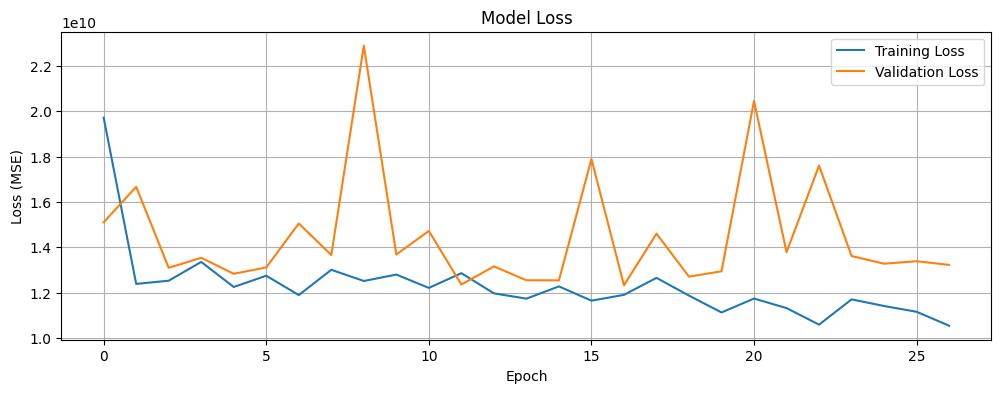

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [16]:
model.save('model/EmbeddingDNNwithLAG_Holiday/final_model.h5')